In [1]:
from pandas import read_csv
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt

In [2]:
import math

folder="./data2023"

users=["Migue", "Noel"]
files=["izq1","sim1","der2","izq2","sim2","der3","izq3"]

users=["NoelOK"]
files=["der1","der3", "izq1","izq2","sim1","sim3"]

sensors=[
    "s1",
    "s2"]


tW=list(range(-1500,50,50))

tStep=500

index_t=0

def cleanDataFile(filename):
    ret = []
    count = 0
    with open(filename) as file:
        for line0 in file:
            count += 1
            line = line0.strip()
            if not line.endswith(';'):
                print("NOT ; in ", count, " -> ", line)
                continue
            line = line[:-1]  # Remove the semicolon at the end
            data = line.split(',')
            if not len(data) == 7:
                print("NOT 7# in ", count, " -> ", line)
                continue
            try:
                ret.append([float(data[0]), float(data[4]), float(data[5]), float(data[6])])
            except:
                print("Error in line ", data)
    return ret

def smoothDataTime(data):
    data[:, 0] = data[:, 0].astype(float)
    tA = []
    lastT = 0
    for jx in range(0, len(data[:, 0])):
        t0 = data[jx, 0]
        if t0 > lastT + 50:
            lastT = t0
            tA.append(t0)

    retV = np.zeros((len(tA), 4))
    for ix in range(1, 5):  # Cambiado a 5 columnas
        data[:, ix - 1] = data[:, ix - 1].astype(float)  
        lastT = 0
        lV = []
        vA = []
        for jx in range(0, len(data[:, ix - 1])): 
            t0 = data[jx, 0]
            if t0 > lastT + 50:
                lastT = t0
                if len(lV) > 0:
                    vA.append(np.median(lV))
                lV = []
            lV.append(data[jx, ix - 1])  

        if len(lV) > 0:
            vA.append(np.median(lV))

        retV[:, ix - 1] = np.array(vA)

    retV[:, 0] = np.array(tA)
    return retV


def process_interval(user_class_path, sensor, start, end, index):
    input_file = os.path.join(user_class_path, f"{sensor}.txt")
    output_file = os.path.join(user_class_path,f"{sensor}-interval{index}.txt")
    output_file_smooth = os.path.join(user_class_path,f"{sensor}-smooth-interval{index}.txt")

    data = pd.DataFrame(cleanDataFile(input_file), columns=["Time", "Yaw", "Pitch", "Roll"])
    interval_data = data[(data["Time"] >= start) & (data["Time"] <= end)]
    #print(interval_data)
    interval_data.to_csv(output_file, index=False, sep='\t')
    smooth=pd.DataFrame(smoothDataTime(interval_data.values), columns=["Time", "Yaw", "Pitch", "Roll"])
    #print(smooth)
    smooth.to_csv(output_file_smooth, index=False, sep='\t')
    
    
def plot_all_intervals(user_class_path, sensor, column, smooth):
    plt.figure(figsize=(15, 8))
    plt.title(f"{user} - {category} - {sensor} - {column} - {'Smooth' if smooth else 'No Smooth'}")
    plt.xlabel("Time")
    plt.ylabel(column)

    for index, row in info_data.iterrows():
        start, end = row["start"], row["end"]
        interval_file = os.path.join(user_class_path, f"{sensor}{'-smooth' if smooth else ''}-interval{index}.txt")
        interval_data = pd.read_csv(interval_file, delimiter='\t')
        plt.plot(interval_data["Time"], interval_data[column], label=f"Interval {index}")

    plt.legend()
    plt.show()
    

def plot_specific_intervals(user, category_pattern, sensor, column, smooth):
    matching_categories = [category for category in os.listdir(os.path.join(folder, user)) if category_pattern in category]

    print("matching_categories:",matching_categories)
    # Gráficas separadas para cada categoría
    for category in matching_categories:
        print("folder, user, category=",folder, user, category)
        user_class_path = os.path.join(folder, user, category)
        info_data = pd.read_csv(os.path.join(user_class_path, "info.txt"), header=None, delimiter='\t', names=["start", "end", "class"])

        plt.figure(figsize=(15, 3))
        plt.title(f"{user} - {category} - {sensor} - {column} - {'Smooth' if smooth else 'No Smooth'}")

        for index, row in info_data.iterrows():
            start, end = row["start"], row["end"]
            interval_file = os.path.join(user_class_path, f"{sensor}{'-smooth' if smooth else ''}-interval{index}.txt")
            interval_data = pd.read_csv(interval_file, delimiter='\t')
            plt.plot(interval_data["Time"], interval_data[column], label=f"Interval {index}")

        plt.legend()
        plt.show()

    # Gráfica unificada para todas las categorías coincidentes
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{user} - {category_pattern} - {sensor} - {column} - {'Smooth' if smooth else 'No Smooth'}")

    for category in matching_categories:
        user_class_path = os.path.join(folder, user, category)
        info_data = pd.read_csv(os.path.join(user_class_path, "info.txt"), header=None, delimiter='\t', names=["start", "end", "class"])

        for index, row in info_data.iterrows():
            start, end = row["start"], row["end"]
            interval_file = os.path.join(user_class_path, f"{sensor}{'-smooth' if smooth else ''}-interval{index}.txt")
            interval_data = pd.read_csv(interval_file, delimiter='\t')

            # Gráfica unificada
            plt.plot(interval_data["Time"], interval_data[column], label=f"{category} - Interval {index}")

    # Mostrar leyendas de gráfica unificada
    plt.legend()
    plt.show()

In [3]:
for user in users:
    for category in files:
        for sensor in sensors:
            user_class_path = os.path.join(folder, user, category)
            info_data = pd.read_csv(os.path.join(user_class_path, "info.txt"), header=None, delimiter='\t', names=["start", "end", "class"])
            
            for index, row in info_data.iterrows():
                start, end = row["start"], row["end"]                
                #print("ini",start,"fin",end)
                process_interval(user_class_path, sensor, start, end, index)
                
            #for column in ["Yaw", "Pitch", "Roll"]:
                #plot_intervals(user_class_path, sensor, column, smooth=False)
                #plot_intervals(user_class_path, sensor, column, smooth=True)

NOT ; in  1  ->  VersiÃ³n de firmware: v10.0
NOT ; in  2  ->  Time(ms), Yaw(Âº), Pitch(Âº), Roll(Âº), AccX(mg), AccY(mg), AccZ(mg)
NOT ; in  1  ->  VersiÃ³n de firmware: v10.0
NOT ; in  2  ->  Time(ms), Yaw(Âº), Pitch(Âº), Roll(Âº), AccX(mg), AccY(mg), AccZ(mg)
NOT ; in  1  ->  VersiÃ³n de firmware: v10.0
NOT ; in  2  ->  Time(ms), Yaw(Âº), Pitch(Âº), Roll(Âº), AccX(mg), AccY(mg), AccZ(mg)
NOT ; in  1  ->  VersiÃ³n de firmware: v10.0
NOT ; in  2  ->  Time(ms), Yaw(Âº), Pitch(Âº), Roll(Âº), AccX(mg), AccY(mg), AccZ(mg)
NOT ; in  1  ->  VersiÃ³n de firmware: v10.0
NOT ; in  2  ->  Time(ms), Yaw(Âº), Pitch(Âº), Roll(Âº), AccX(mg), AccY(mg), AccZ(mg)
NOT ; in  1  ->  VersiÃ³n de firmware: v10.0
NOT ; in  2  ->  Time(ms), Yaw(Âº), Pitch(Âº), Roll(Âº), AccX(mg), AccY(mg), AccZ(mg)
NOT ; in  1  ->  VersiÃ³n de firmware: v10.0
NOT ; in  2  ->  Time(ms), Yaw(Âº), Pitch(Âº), Roll(Âº), AccX(mg), AccY(mg), AccZ(mg)
NOT ; in  1  ->  VersiÃ³n de firmware: v10.0
NOT ; in  2  ->  Time(ms), Yaw(Âº), Pi

matching_categories: ['der1', 'der3']
folder, user, category= ./data2023 NoelOK der1


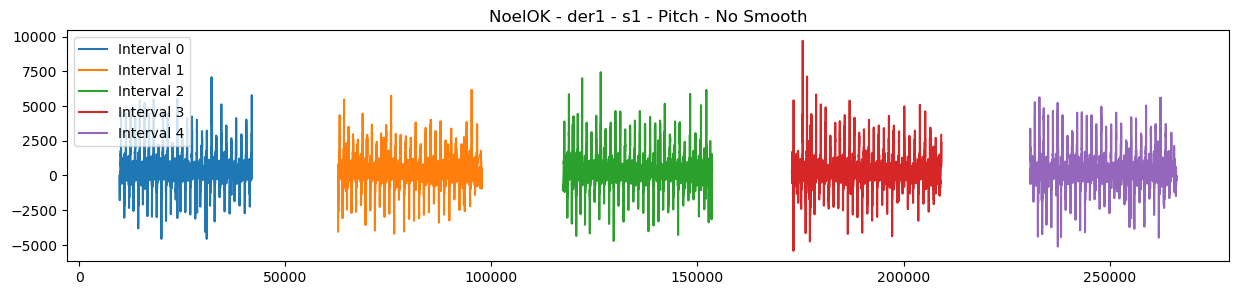

folder, user, category= ./data2023 NoelOK der3


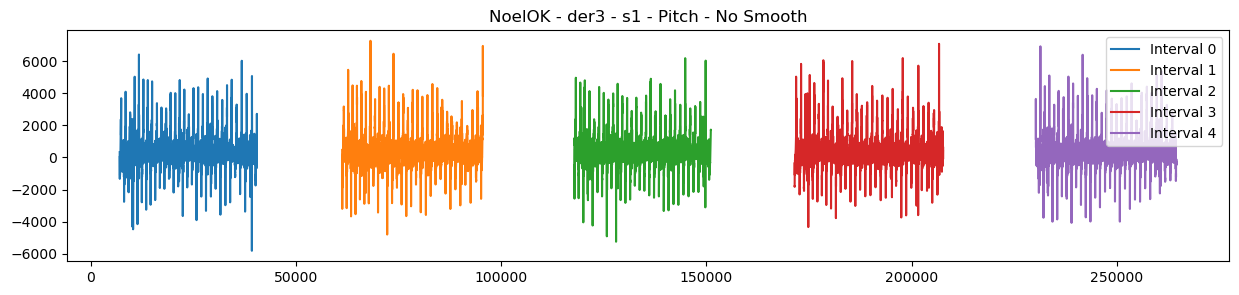

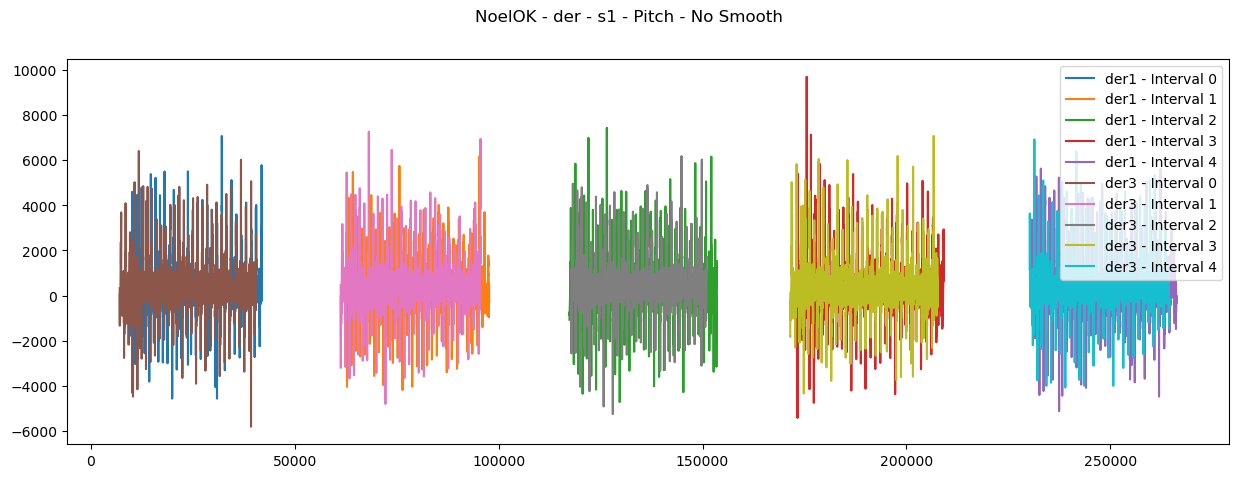

matching_categories: ['der1', 'der3']
folder, user, category= ./data2023 NoelOK der1


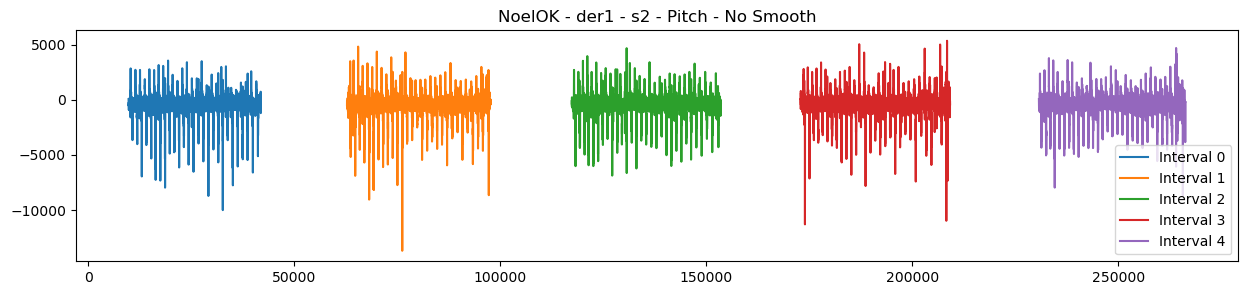

folder, user, category= ./data2023 NoelOK der3


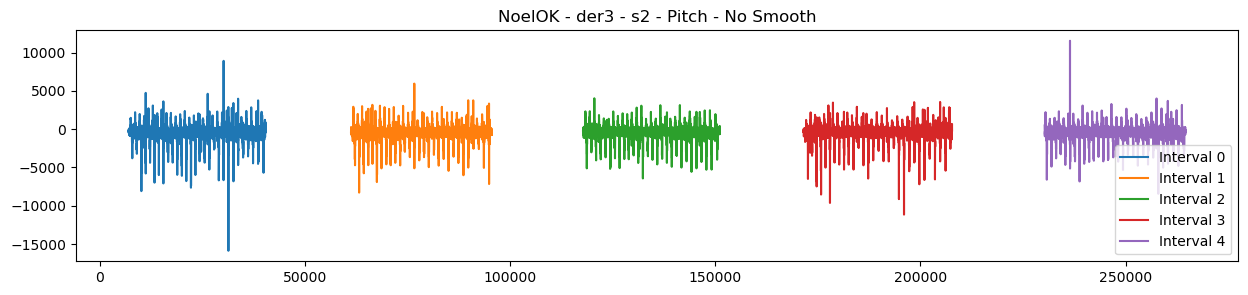

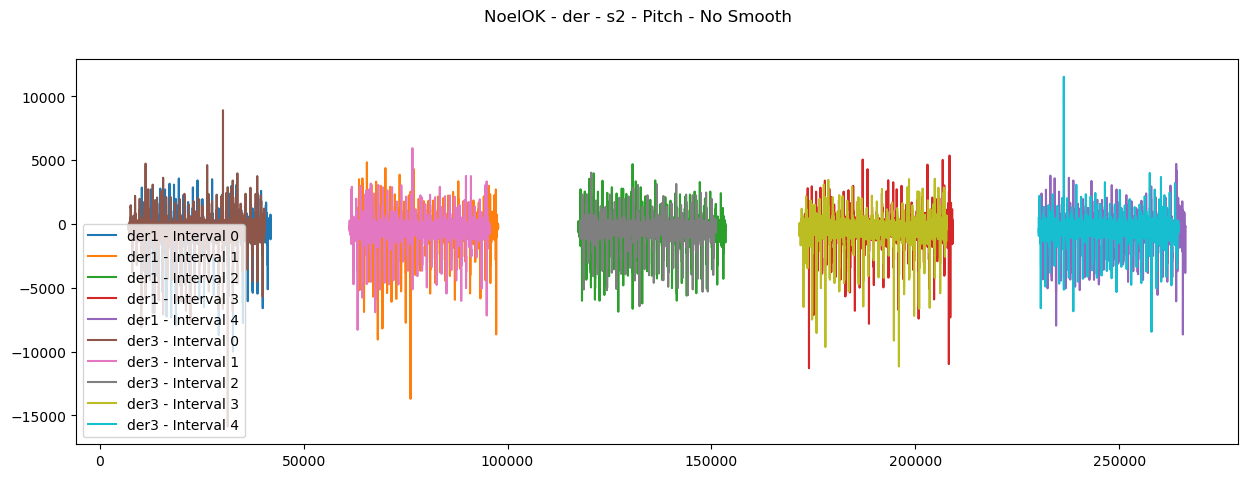

matching_categories: ['der1', 'der3']
folder, user, category= ./data2023 NoelOK der1


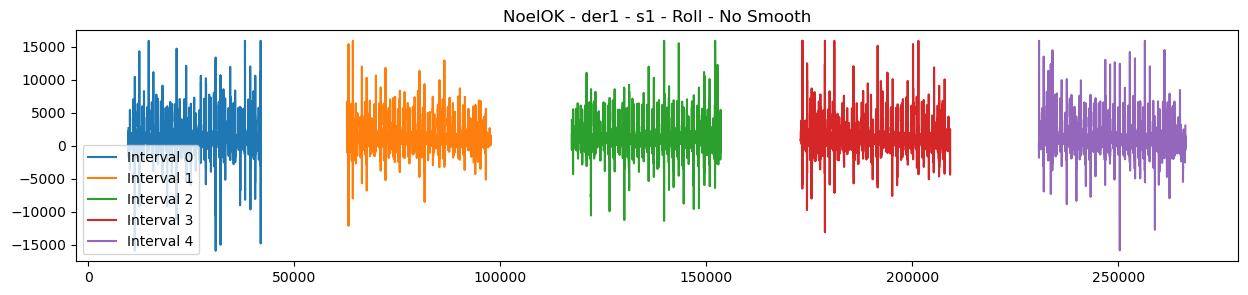

folder, user, category= ./data2023 NoelOK der3


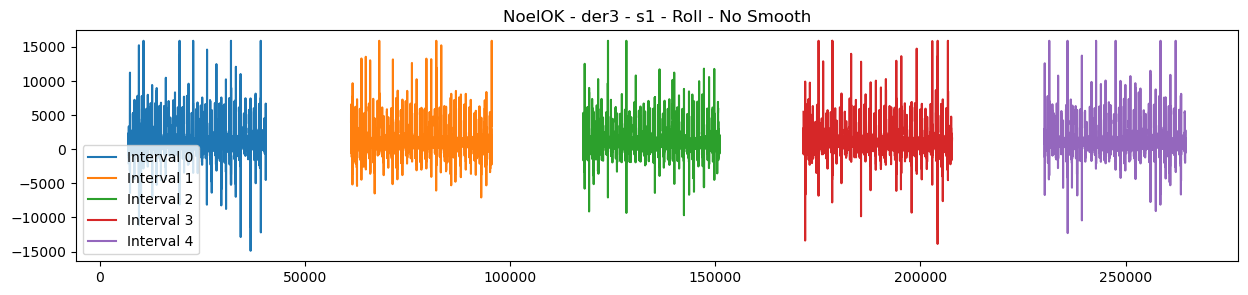

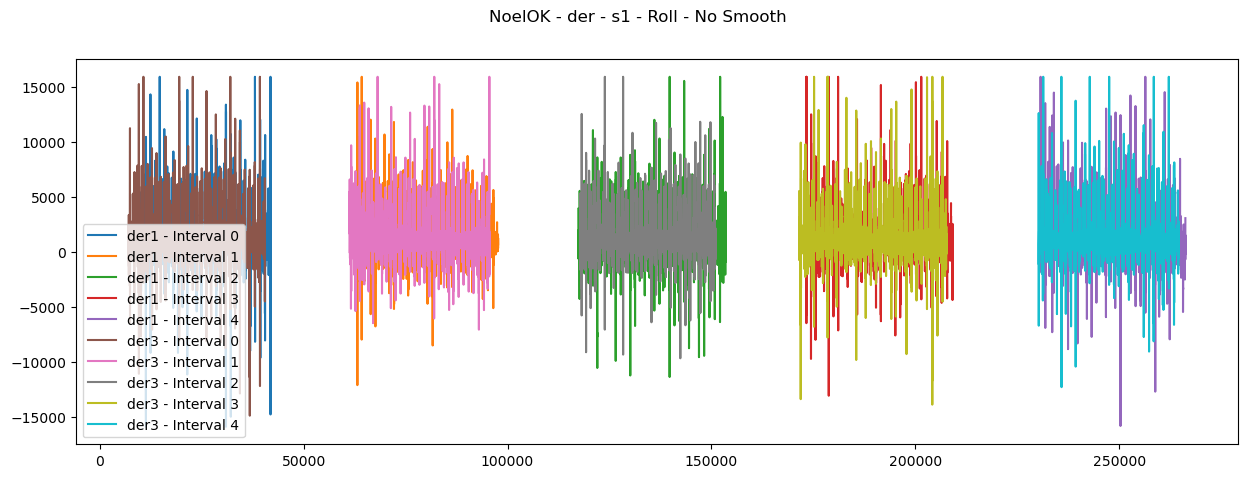

matching_categories: ['der1', 'der3']
folder, user, category= ./data2023 NoelOK der1


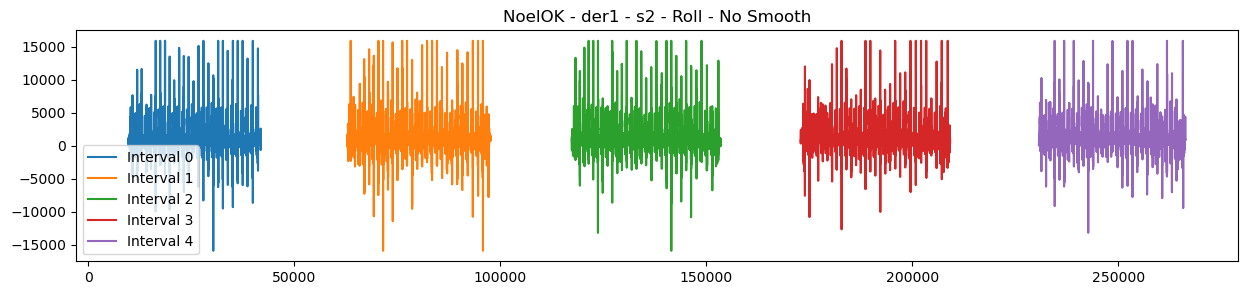

folder, user, category= ./data2023 NoelOK der3


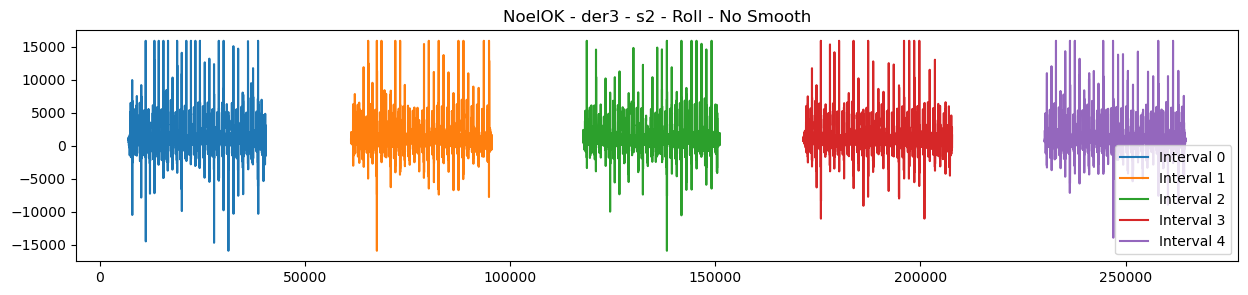

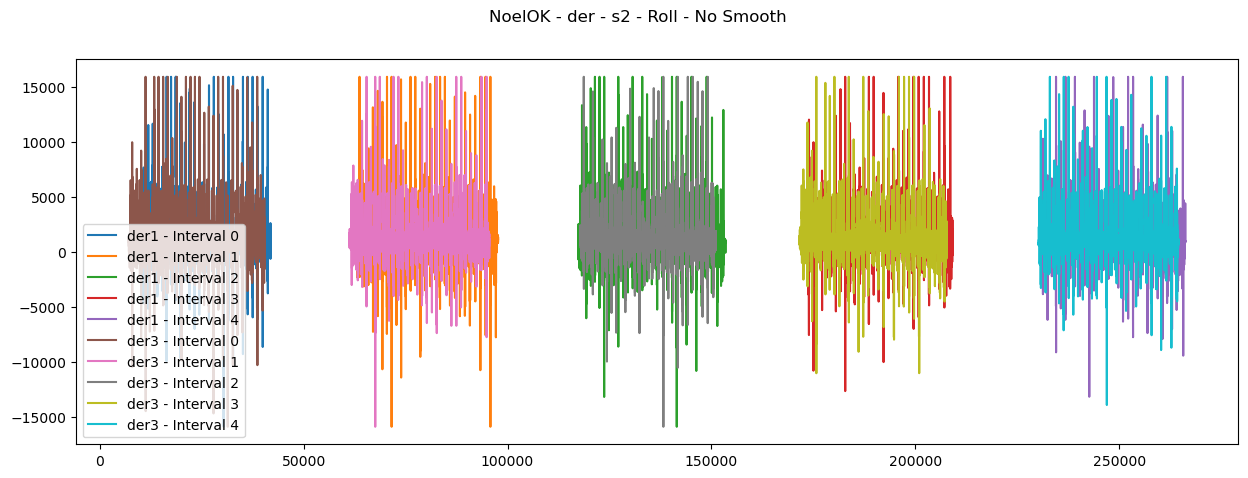

matching_categories: ['der1', 'der3']
folder, user, category= ./data2023 NoelOK der1


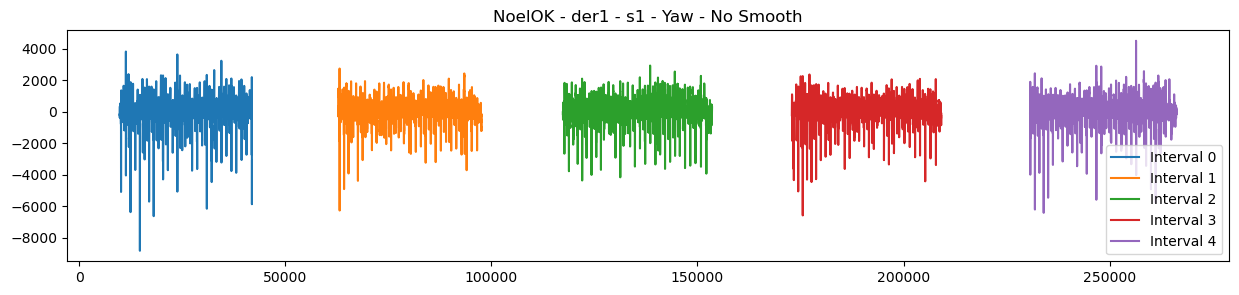

folder, user, category= ./data2023 NoelOK der3


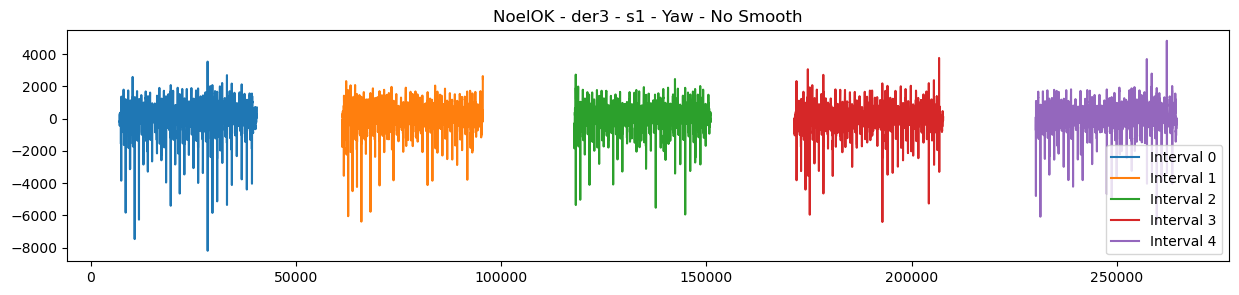

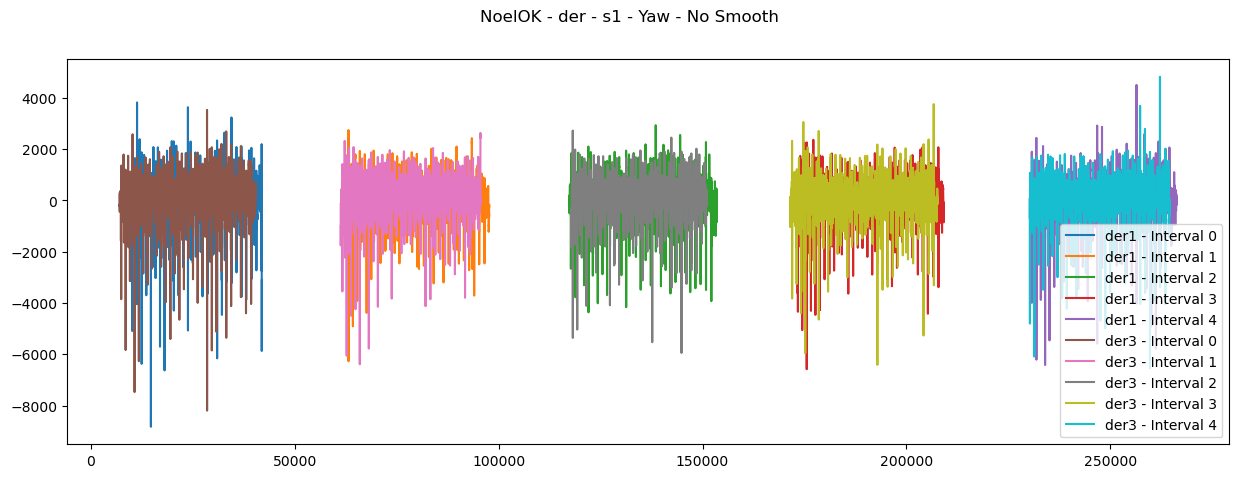

matching_categories: ['der1', 'der3']
folder, user, category= ./data2023 NoelOK der1


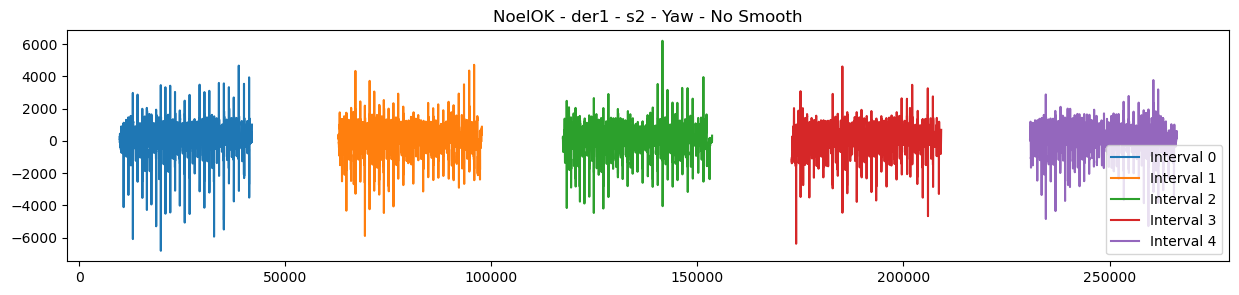

folder, user, category= ./data2023 NoelOK der3


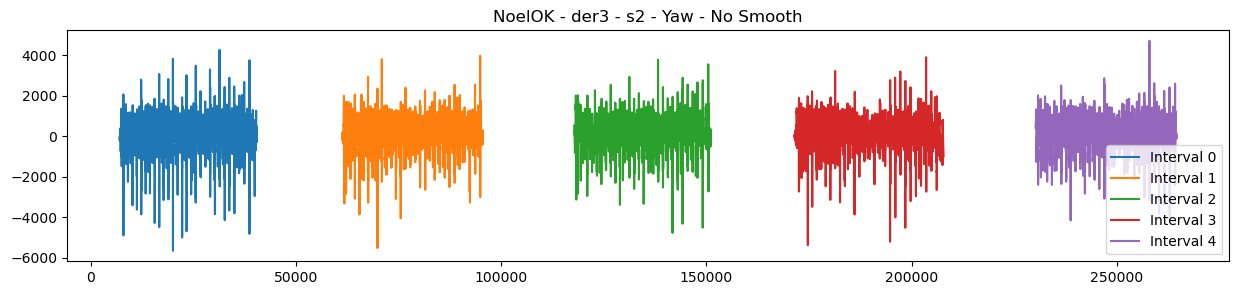

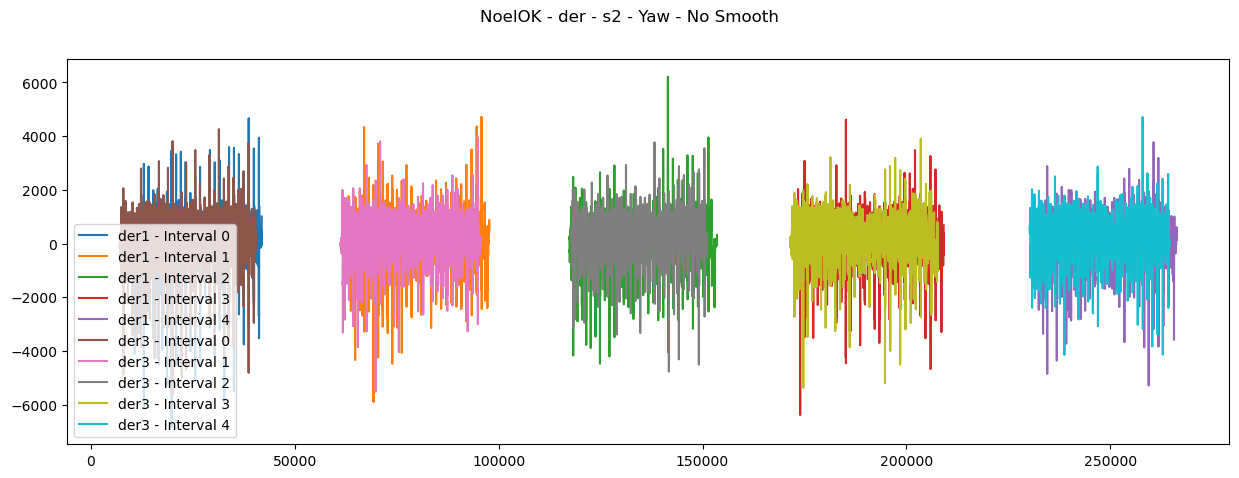

In [4]:
plot_specific_intervals("NoelOK", "der", "s1", "Pitch", smooth=False)
plot_specific_intervals("NoelOK", "der", "s2", "Pitch", smooth=False)
plot_specific_intervals("NoelOK", "der", "s1", "Roll", smooth=False)
plot_specific_intervals("NoelOK", "der", "s2", "Roll", smooth=False)
plot_specific_intervals("NoelOK", "der", "s1", "Yaw", smooth=False)
plot_specific_intervals("NoelOK", "der", "s2", "Yaw", smooth=False)